In [1]:
import cv2

def enhance_contrast(img):
    img_equalized = cv2.equalizeHist(img)
    return img_equalized


In [2]:
def enhance_local_contrast(img):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    return img_clahe


In [3]:
def apply_threshold(img, threshold=235):
    _, img_threshold = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return img_threshold


In [4]:
def apply_adaptive_threshold(img, block_size=21, c=7):
    img_adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size,c)
    return img_adaptive


In [5]:
import cv2
import numpy as np

def apply_standardization(img):
    # Convert to float32
    img_float32 = img.astype(np.float32)

    # Calculate mean and standard deviation for each channel
    means, stds = cv2.meanStdDev(img_float32, mask=None)

    # Standardize each channel separately
    img_standardized = (img_float32 - means) / stds

    # Normalize to the range [0, 255]
    img_standardized = (img_standardized - np.min(img_standardized)) / (np.max(img_standardized) - np.min(img_standardized)) * 255

    # Convert back to uint8
    img_standardized = np.clip(img_standardized, 0, 255).astype(np.uint8)

    return img_standardized



In [6]:
def apply_gaussian_blur(img):
    img_blurred = cv2.GaussianBlur(img, (3, 3), 0)
    return img_blurred


In [7]:
import matplotlib.pyplot as plt
def plot_images_side_by_side(image_array, titles=None):
    """
    Plot images side by side.

    Parameters:
    - image_array: List of images (numpy arrays).
    - titles: List of titles for each image.
    """
    # titles = ['Image 1', 'Image 2', 'Image 3']
    num_images = len(image_array)
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

    for i in range(num_images):
        axes[i].imshow(cv2.cvtColor(image_array[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
        if titles is not None:
            axes[i].set_title(titles[i])

    plt.show()

In [8]:
def clean_signature(img, threshold):
    img_cleaned = cv2.medianBlur(img, threshold)
    return img_cleaned

In [9]:
def remove_salt_noise(img, kernel_size=3, iterations=1):
    # Create a kernel for erosion
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Erode the image to remove salt-like noise
    img_eroded = cv2.erode(img, kernel, iterations=iterations)

    return img_eroded

In [10]:
def remove_noise_cross_number(img, threshold=5):
    # Invert the image (black becomes white, and vice versa)
    img_inverted = 255 - img

    # Define a kernel with a cross-shaped structuring element
    kernel = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]], dtype=np.uint8)

    # Count the number of foreground pixels in the neighborhood
    pixel_count = cv2.filter2D(img_inverted, -1, kernel)

    # Thresholding based on the pixel count
    img_filtered = np.where(pixel_count >= threshold, img_inverted, 255)

    # Invert the image back
    img_filtered = 255 - img_filtered

    return img_filtered

In [13]:
SIZE=224

In [11]:
img1 = cv2.imread('beshara2.png')
img2 = cv2.imread('beshara1.png')
img3 = cv2.imread('salman.png')
img4 = cv2.imread('dina.png')
img5 = cv2.imread('mai.png')
img6 = cv2.imread('mariam.png')


In [14]:
# Resize the image
img1 = cv2.resize(img1, (SIZE,SIZE))
img2 = cv2.resize(img2, (SIZE,SIZE))
img3 = cv2.resize(img3, (SIZE,SIZE))
img4 = cv2.resize(img4, (SIZE,SIZE))
img5 = cv2.resize(img5, (SIZE,SIZE))
img6 = cv2.resize(img6, (SIZE,SIZE))

images_array= [img1, img2, img3, img4, img5, img6]
for i in range(len(images_array)):
      # Convert the image to grayscale
      images_array[i] = cv2.cvtColor(images_array[i], cv2.COLOR_BGR2GRAY)


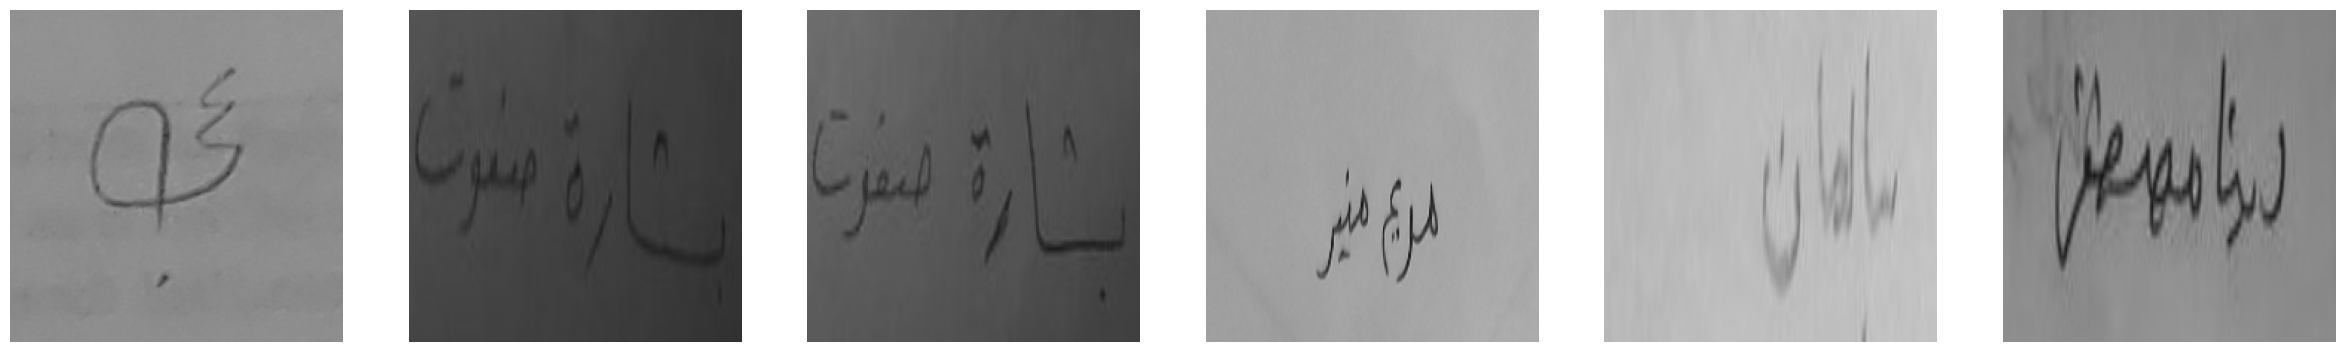

In [ ]:
plot_images_side_by_side(images_array)

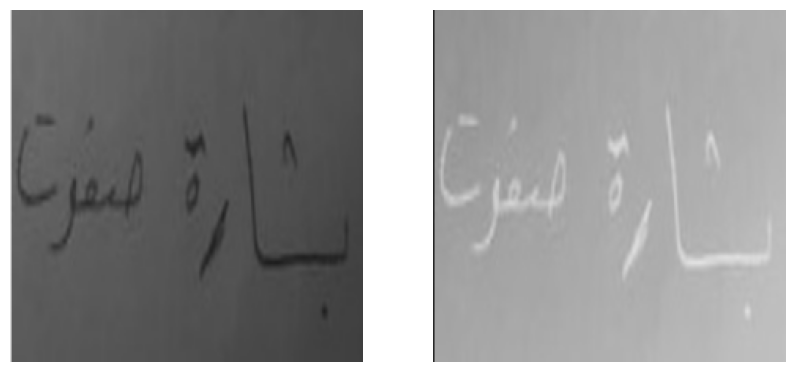

In [15]:
image_complement = cv2.bitwise_not(images_array[0])
plot_images_side_by_side([images_array[0],image_complement])

In [16]:
import cv2
import numpy as np

def ridge_thinning(image):

    # Binarize the image (convert to black and white)
    img = apply_adaptive_threshold(image, 55,6)

    # Perform ridge thinning
    thinned_image = thinning(img)

    return thinned_image

def thinning(img):
    img = img.copy()
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    ret, img = cv2.threshold(img, 128, 255, 0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False

    while not done:
        eroded = cv2.erode(img, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros == size:
            done = True

    return skel

# img = ridge_thinning(images[5])
# plot_images_side_by_side([img, images[5]])


In [17]:
def whiten_black_neighbours(img, threshold):
  """
  Replaces black pixels with white if they have at least `threshold` white neighbours.

  Args:
    img: A 2D numpy array representing the image.
    threshold: The minimum number of white neighbours required to whiten a black pixel.

  Returns:
    A new 2D numpy array with replaced black pixels.
  """
  # Create a copy of the image
  white_img = img.copy()

  # Define the search directions for neighbours
  directions = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1), (0, 1),
               (1, -1), (1, 0), (1, 1)]

  # Iterate over each pixel
  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      # Check if the pixel is black
      if img[row, col] == 0:
        # Count the number of white neighbours
        white_neighbours = 0
        for dx, dy in directions:
          neighbour_row, neighbour_col = row + dy, col + dx
          # Check if neighbour is within image bounds
          if 0 <= neighbour_row < img.shape[0] and 0 <= neighbour_col < img.shape[1]:
            if img[neighbour_row, neighbour_col] == 255:
              white_neighbours += 1

        # If the number of white neighbours is greater than or equal to the threshold, whiten the pixel
        if white_neighbours >= threshold:
          white_img[row, col] = 255

  return white_img

In [ ]:
import cv2
import numpy as np

def blacken_white_neighbours(img, threshold):
  """
  Blackens white pixels if they have more than `threshold` black neighbours.

  Args:
    img: A 2D numpy array representing the image.
    threshold: The maximum number of black neighbours allowed for a white pixel to remain white.

  Returns:
    A new 2D numpy array with blackened white pixels.
  """
  # Create a copy of the image
  black_img = img.copy()

  # Define the search directions for neighbours
  directions = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1), (0, 1),
               (1, -1), (1, 0), (1, 1)]

  # Iterate over each pixel
  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      # Check if the pixel is white
      if img[row, col] == 255:
        # Count the number of black neighbours
        black_neighbours = 0
        for dx, dy in directions:
          neighbour_row, neighbour_col = row + dy, col + dx
          # Check if neighbour is within image bounds
          if 0 <= neighbour_row < img.shape[0] and 0 <= neighbour_col < img.shape[1]:
            if img[neighbour_row, neighbour_col] == 0:
              black_neighbours += 1

        # If the number of black neighbours is greater than the threshold, blacken the pixel
        if black_neighbours > threshold:
          black_img[row, col] = 0

  return black_img



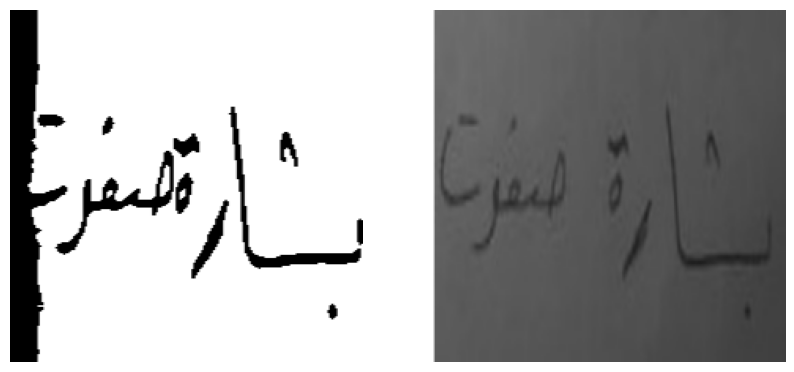

In [18]:
import numpy as np
import cv2
SIZE= 224
def trim_zeros(arr, threshold):
  """
  Trims rows and columns of a 2D array with too many zeros.

  Args:
    arr: A 2D numpy array.
    threshold: The maximum number of zeros allowed in a row or column.

  Returns:
    A trimmed 2D numpy array.
  """
  # Trim rows
  row_sums = np.sum(arr, axis=1)
  keep_rows = row_sums > threshold
  trimmed_arr = arr[keep_rows, :]

  # Trim columns
  col_sums = np.sum(trimmed_arr, axis=0)
  keep_cols = col_sums > threshold
  trimmed_arr = trimmed_arr[:, keep_cols]
  trimmed_arr = trimmed_arr.astype(np.uint8)
  trimmed_arr = cv2.resize(trimmed_arr, (SIZE, SIZE))
  # Resize the array back to its original size
  # trimmed_arr = np.pad(trimmed_arr, ((0, arr.shape[0] - trimmed_arr.shape[0]),
  #                                     (0, arr.shape[1] - trimmed_arr.shape[1])),
  #                       mode='constant', constant_values=0)
  return trimmed_arr
def trim_white(arr, threshold):
  """
  Trims rows and columns of a 2D array with too many 255s (white pixels).

  Args:
    arr: A 2D numpy array.
    threshold: The maximum number of 255s allowed in a row or column.

  Returns:
    A trimmed 2D numpy array.
  """
  # Invert the array to treat 255s as zeros
  inverted_arr = 255 - arr
  # Use the original function to trim rows and columns based on zeros
  trimmed_arr = trim_zeros(inverted_arr, threshold)
  # Invert the trimmed array back to original values
  trimmed_arr = 255 - trimmed_arr
  # Convert the data type to uint8 for image processing
  trimmed_arr = trimmed_arr.astype(np.uint8)
  # Resize the array to the desired size
  trimmed_arr = cv2.resize(trimmed_arr, (SIZE, SIZE))
  return trimmed_arr


threshold = 180
img = apply_adaptive_threshold(images_array[0], 55,6)
img = whiten_black_neighbours(img , 4)
img = trim_white(img, 180)
# img = cv2.bitwise_not(img)


plot_images_side_by_side([img, img1])


In [19]:
def process_image_pipeline(img):

    img = apply_adaptive_threshold(img, 55,6)
    img = clean_signature(img,3)
    img = remove_salt_noise(img, 1, 2)
    img = apply_threshold(img, 250)

    return img


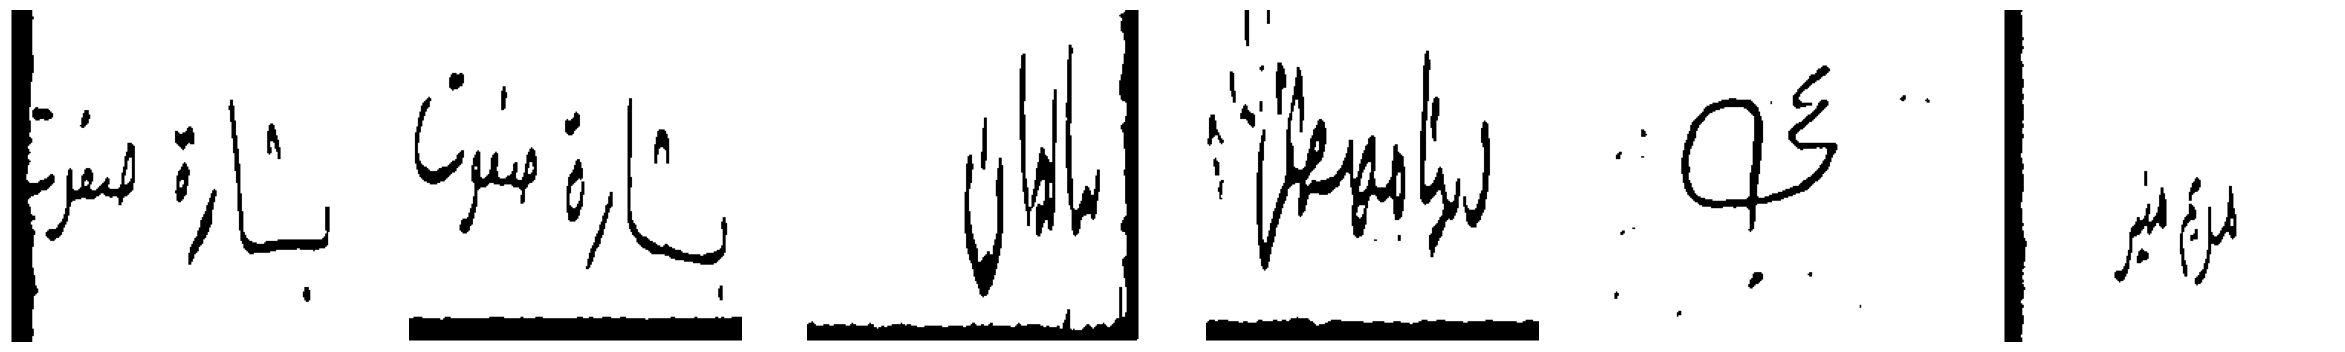

In [20]:
images = [process_image_pipeline(img) for img in images_array ]
plot_images_side_by_side(images)

In [21]:
def process_image_pipeline2(img):
   img = apply_adaptive_threshold(img, 55,6)
   img = clean_signature(img,3)
   img = whiten_black_neighbours(img , 4)
   img = trim_white(img, 180)
   return img

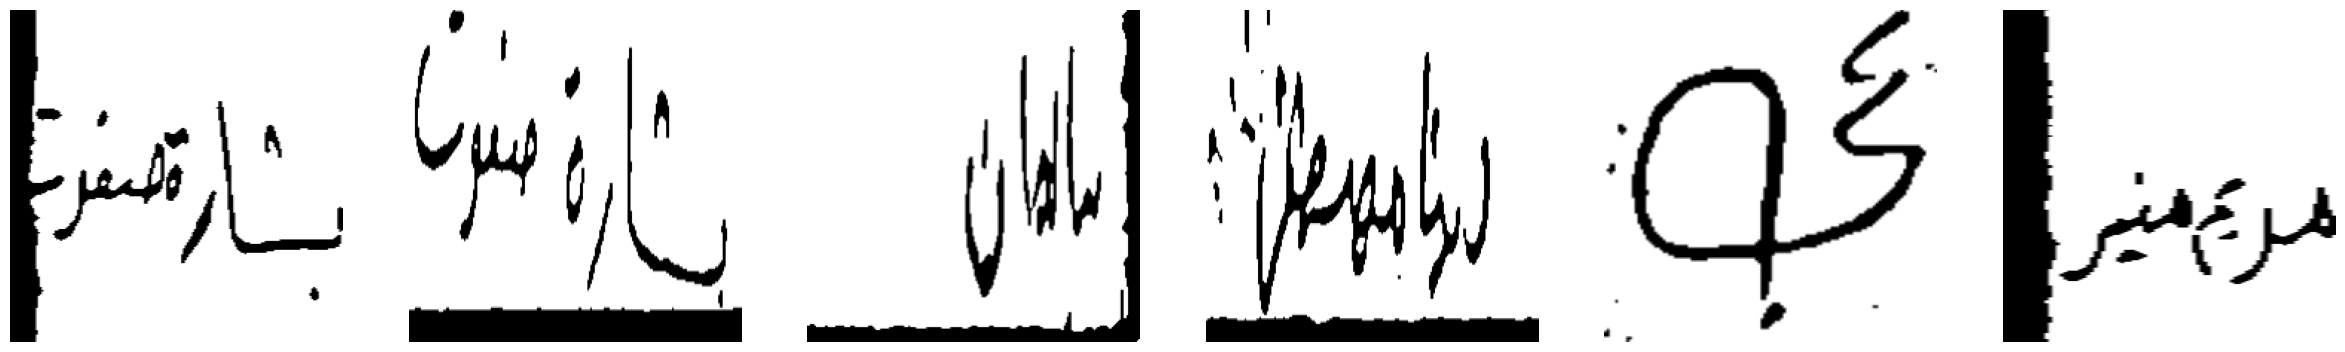

In [22]:
images2 = [process_image_pipeline2(img) for img in images_array ]
plot_images_side_by_side(images2)




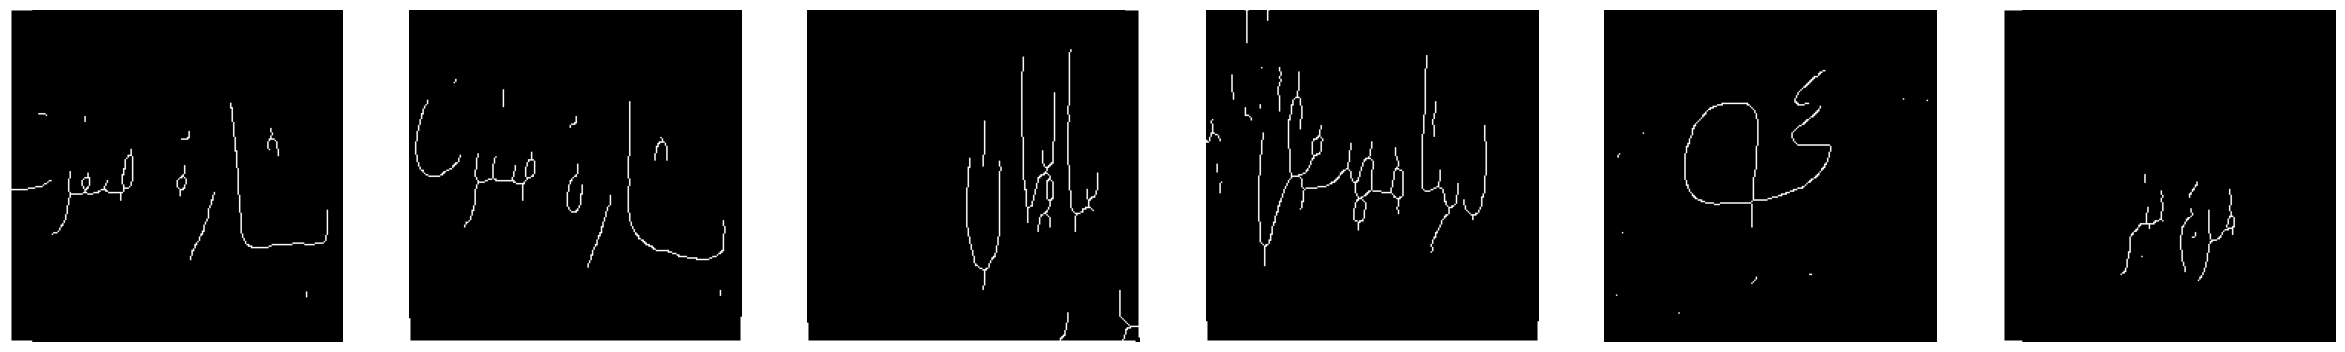

In [37]:
def Thining(img):
    blurred_image = cv2.GaussianBlur(img, (5, 5), 0)
    binary_image = cv2.bitwise_not(blurred_image)
    thinning_image = cv2.ximgproc.thinning(binary_image)
    
    return thinning_image


images3 = [Thining(img) for img in images ]
plot_images_side_by_side(images3)
